In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Flatten, Dense, Activation, Input, GlobalAveragePooling2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
file_path = '/content/drive/MyDrive/Emotion_model/merged_disgust.csv'

In [4]:
df = pd.read_csv(file_path)
print(df.head())

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40429 entries, 0 to 40428
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  40429 non-null  int64 
 1   pixels   40429 non-null  object
dtypes: int64(1), object(1)
memory usage: 631.8+ KB
None


In [6]:
df.shape

(40429, 2)

In [7]:
print(df['emotion'].value_counts())

emotion
3    8989
6    6198
4    6077
2    5121
1    5089
0    4953
5    4002
Name: count, dtype: int64


In [8]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,5089


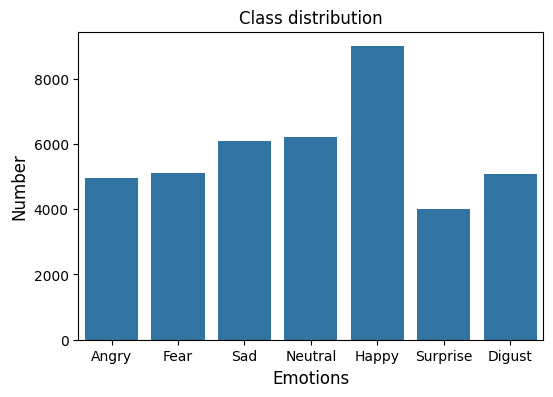

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(x='emotion', y='number', data=emotion_counts)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

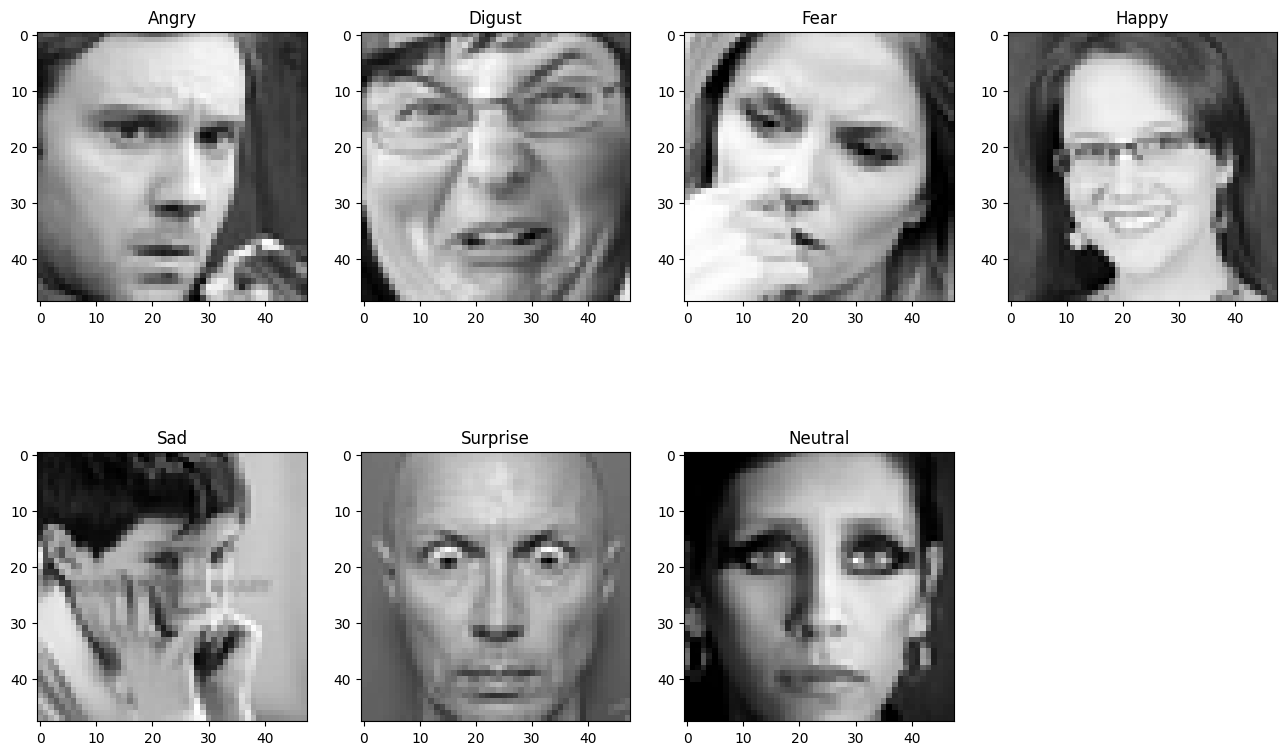

In [10]:
def row2image(row):
    pixels = np.array([int(p) for p in row['pixels'].split()]).reshape(48,48)
    label = emotion_map[row['emotion']]
    return pixels, label

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0], cmap='gray')
    plt.title(img[1])

plt.show()

In [11]:
print(df.columns)

Index(['emotion', 'pixels'], dtype='object')


In [44]:
from sklearn.model_selection import train_test_split

# Separate features and labels
X = df['pixels']
y = df['emotion']

# Convert pixels from string to array
import numpy as np
X = np.array([np.fromstring(pixel_seq, sep=' ') for pixel_seq in X], dtype='float32')
X = X.reshape(-1, 48, 48, 1)  # if your images are 48x48 grayscale

# One-hot encode labels
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=7)

# Split into train (80%), validation (10%), test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check shapes
print("Train shape: {}, Validation shape: {}, Test shape: {}".format(
    X_train.shape, X_val.shape, X_test.shape))

Train shape: (32343, 48, 48, 1), Validation shape: (4043, 48, 48, 1), Test shape: (4043, 48, 48, 1)


In [45]:
X_train = X_train / 255.0
X_val   = X_val / 255.0
X_test  = X_test / 255.0

In [46]:
import numpy as np

# Flatten images to 1D for comparison
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Find unique indices
_, unique_indices = np.unique(X_train_flat, axis=0, return_index=True)

# Keep only unique samples
X_train = X_train[unique_indices]
y_train = y_train[unique_indices]

print("After removing duplicates, Train shape:", X_train.shape)

After removing duplicates, Train shape: (30937, 48, 48, 1)


### Data Augmentation

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

datagen.fit(X_train)

### Normalize consistently

In [48]:
mean = X_train.mean()
std  = X_train.std()

X_train = (X_train - mean) / std
X_val   = (X_val - mean) / std
X_test  = (X_test - mean) / std

### Model Architecture

In [60]:

def DeepS_Emotion_Baseline():
  model = Sequential()
  model.add(Input(shape=(48,48,1)))

  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(0.25))


  # Block 2
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  # Block 3
  model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(0.3))


  # Block 4 (This code is added to improve performance)
  model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
  model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(GlobalAveragePooling2D())

  # Dense layers
  model.add(Dense(1024, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))

  # Compile
  model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )
  return model
model = DeepS_Emotion_Baseline()

In [61]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,224,647 (19.93 MB)

 Trainable params: 5,220,679 (19.92 MB)

 Non-trainable params: 3,968 (15.50 KB)

### Callbacks

In [62]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

### Training

In [63]:
batch_size = 64
epochs = 100

model = DeepS_Emotion_Baseline()

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


484/484 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.1675 - loss: 2.6804 - val_accuracy: 0.1370 - val_loss: 3.6869 - learning_rate: 1.0000e-04
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.2025 - loss: 2.3782 - val_accuracy: 0.2323 - val_loss: 3.3702 - learning_rate: 1.0000e-04
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.2487 - loss: 2.1498 - val_accuracy: 0.3213 - val_loss: 2.0853 - learning_rate: 1.0000e-04
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.2936 - loss: 1.9915 - val_accuracy: 0.3203 - val_loss: 2.2282 - learning_rate: 1.0000e-04
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.3372 - loss: 1.8434 - val_accuracy: 0.3824 - val_loss: 1.7093 - learning_rate: 1.0000e-04
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - accuracy: 0.3625 - loss: 1.7696 - val_accuracy: 0.4294 - val_loss: 1.5848 - learning_rate: 1.0000e-04
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - a

In [66]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6599 - loss: 0.9768
Test Accuracy: 0.6547, Test Loss: 0.9996


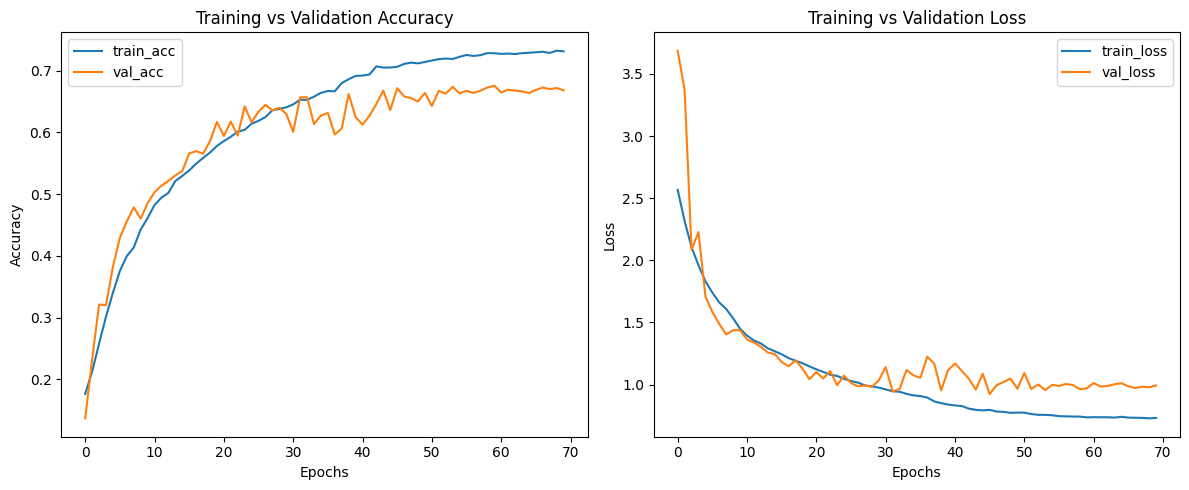

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax[0].plot(history.history['accuracy'], label='train_acc')
ax[0].plot(history.history['val_accuracy'], label='val_acc')
ax[0].set_title('Training vs Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss plot
ax[1].plot(history.history['loss'], label='train_loss')
ax[1].plot(history.history['val_loss'], label='val_loss')
ax[1].set_title('Training vs Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

In [68]:
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


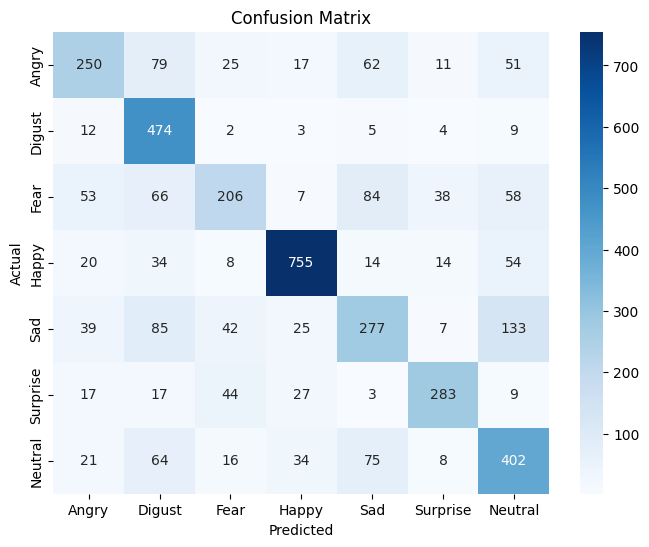

In [69]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[emotion_map[i] for i in range(7)],
            yticklabels=[emotion_map[i] for i in range(7)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

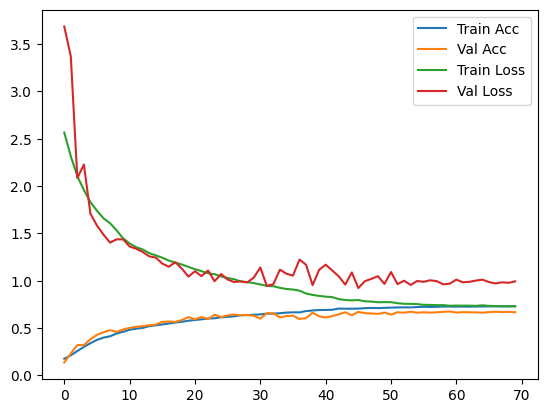

In [70]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [71]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[emotion_map[i] for i in range(7)]))

Classification Report:
              precision    recall  f1-score   support

       Angry       0.61      0.51      0.55       495
      Digust       0.58      0.93      0.71       509
        Fear       0.60      0.40      0.48       512
       Happy       0.87      0.84      0.85       899
         Sad       0.53      0.46      0.49       608
    Surprise       0.78      0.71      0.74       400
     Neutral       0.56      0.65      0.60       620

    accuracy                           0.65      4043
   macro avg       0.65      0.64      0.63      4043
weighted avg       0.66      0.65      0.65      4043



In [76]:
model.save("/content/drive/MyDrive/Emotion_model/DeepS_emotion_model_V2.keras")
print("Model saved successfully!")

Model saved successfully!


In [73]:
import os
print(os.getcwd())

/content
